<a href="https://colab.research.google.com/github/InutilemMachina/DataSciRepo/blob/main/KMeansOfSpectrums_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-means clustering of spectrums

## Import, setup

In [ ]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 8

def plotlabels(ax,title,xlabel,ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.autoscale(enable=True, axis='both', tight=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd /content/drive/MyDrive/Colab Notebooks/remotear

audio_files = [
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303185219-gephaz-korbe.wav',
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303185649-mk-kibe.wav',
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303200550-leallas-zsalumozgato.wav',
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303200822-lk-leallas.wav']

audio_titles = ["gephaz-korbe", "mk-kibe", "leallas-zsalumozgato", "lk leallas"]

"""
audio_files = [
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303185219-gephaz-korbe.wav',
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303185649-mk-kibe.wav',
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303200550-leallas-zsalumozgato.wav',
    '/content/drive/MyDrive/Colab Notebooks/remotear/record20230303200822-lk-leallas.wav']
"""

signalIX = 0  # possible values 0,1,2,3 means the 1st, 2nd, 3rd, 4th signal
print(f"Title: {audio_titles[signalIX]}")  # Display title

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/remotear
Title: gephaz-korbe


In [ ]:
import math
# !pip install librosa
import librosa

def read_signal(audio_file):
    x0, fs = librosa.load(audio_file, sr=None)  # read audio-file

    num_sec = len(x0)/fs  # number of seconds
    num_sec_floor = math.floor(num_sec) # floor of number of seconds
    sec_last_index = num_sec_floor*fs  # index upper limit

    x = x0[0:sec_last_index]  # ez itt az utolsó egész másodpercre csonkolja le
     # a jelet, így a "sig" változótól minimálisan különböző a mérete

    print('sampling frequency, fs=' + str(fs) + 'Hz')
    return x, fs

In [ ]:
x, fs = read_signal(audio_files[signalIX])

sampling frequency, fs=8000Hz


In [ ]:
import scipy.signal as signal
import numpy as np

def spectro(x, fs, winsize):
    windowsize = winsize
    noverlap = round(windowsize/1.5)
    freqs = windowsize/2+1
    F, T, S = signal.spectrogram(x, fs=fs, window='hann', nperseg=windowsize, noverlap=noverlap)
    P = np.abs(S)
    return F, T, P

In [ ]:
F, T, P = spectro(x, fs, 512)  # x, fs, 512

print('T:', np.shape(T), min(T), max(T))
print('F:', np.shape(F), min(F), max(F))
print('P:', np.shape(P))

T: (11226,) 0.032 239.966375
F: (257,) 0.0 4000.0
P: (257, 11226)


In [ ]:
import matplotlib.pyplot as plt

def freq_plotter(T, F, P):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=[25, 4])
    im = ax1.pcolormesh(T, F, 20*np.log10(P), shading = 'gouraud', cmap='plasma')

    # shading: 'flat', 'nearest', 'gouraud', 'auto'
    # cmap: 'jet', 'viridis', 'plasma', 'magma', 'cividis', 'inferno', 'gray'

    ax1.set_title('Signal')
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel('f [Hz]')
    ax1.grid(True)
    ax1.axis('tight')

    # Create the secondary axis for mm:ss notation
    ax2 = ax1.twiny()

    # Define the tick positions for the secondary axis
    # tick_positions = np.linspace(0, int(T[-1]), 20)  # Adjust the density as needed
    tick_positions = list(range(0,int(T[-1]),10))

    # Convert tick positions to mm:ss notation
    tick_labels = []
    for pos in tick_positions:
        minutes = int(pos // 60)
        seconds = int(pos % 60)
        tick_labels.append(f'{minutes:02d}:{seconds:02d}')

    # Set the tick positions and labels for the secondary axis
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)

    # Set the font size and rotation for the tick labels on the secondary axis
    ax2.tick_params(axis='x', labelsize=8, rotation=90)

    # Set the limits and label for the secondary axis
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xlabel('t [mm:ss]')
    """
    # Add a colorbar below ax1
    cbar_ax = fig.add_axes([ax1.get_position().x0, ax1.get_position().y0 - 0.15, ax1.get_position().width, 0.03])
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')

    # Add labels to the colorbar
    cbar.set_label('X [dB]')
    """
    # Show the plot
    # plt.show()

    # ha plt.show()-t nem használjuk, akkor utólag még tudunk rá plottolni, juhéé :)
    # de akkor a colorbarnak is bucsut kell mondanunk :(

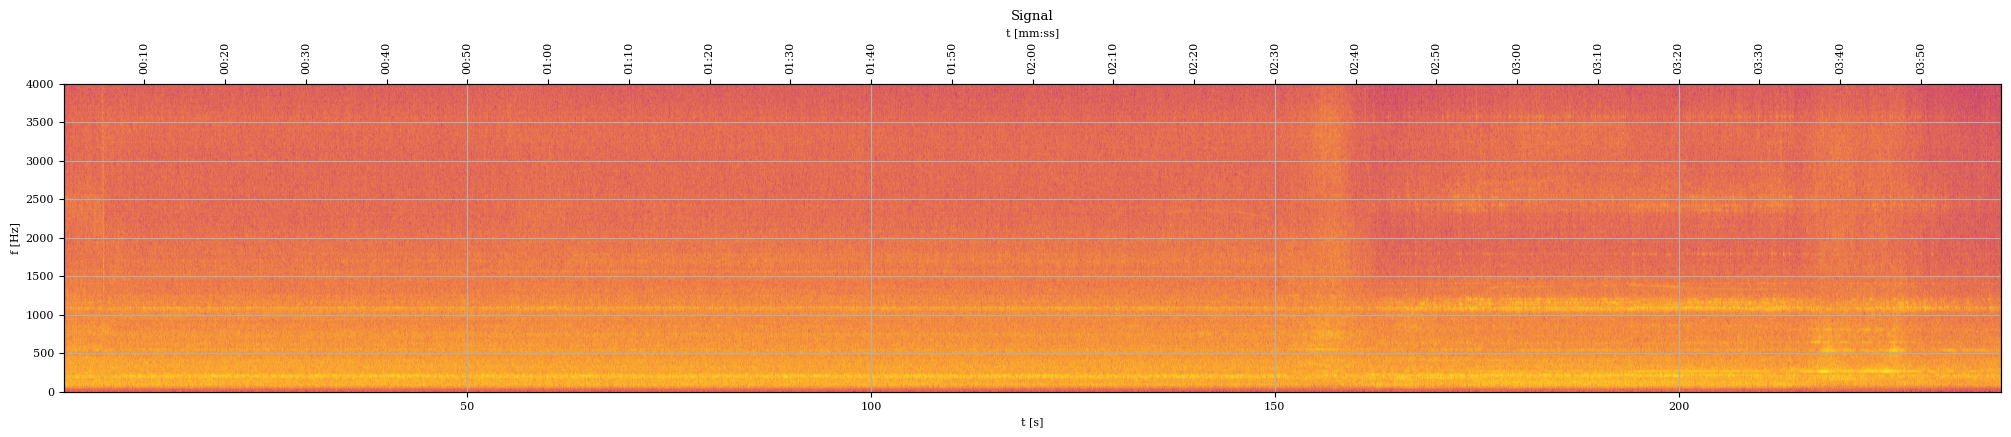

In [ ]:
# freq_plotter(T, F, P)

## Example in lower dimensions
Credits: https://realpython.com/k-means-clustering-python/

In [ ]:
%pip install kneed
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler  # << not welcomed here

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# make some blabla data for the example
features, true_labels = make_blobs(
    n_samples=100,
    centers=3,
    cluster_std=1.5,
    random_state=42
)

In [ ]:
features[:5]

array([[-8.14981777, -9.15238043],
       [ 5.86015466,  0.12687321],
       [-3.2134092 ,  9.82812619],
       [ 6.7440703 , -0.12960691],
       [-6.34294615, -6.0389328 ]])

In [ ]:
true_labels[:5]

array([2, 1, 0, 1, 2])

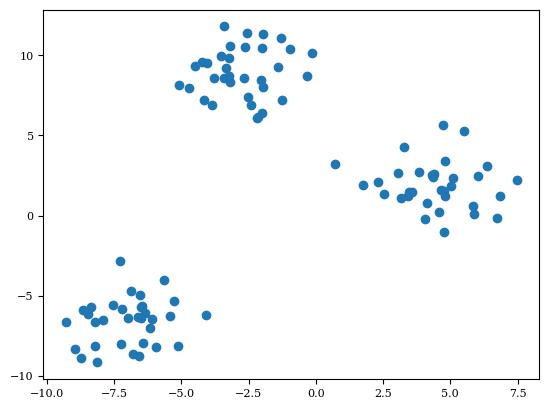

In [ ]:
x = np.asarray(features[:,0])
y = np.asarray(features[:,1])
plt.scatter(x,y)

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42)

kmeans.fit(features)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [ ]:
kmeans.inertia_ # The lowest SSE value

386.79971532879875

In [ ]:
kmeans.cluster_centers_ # Final locations of the centroid

array([[ 4.42932559,  1.92179535],
       [-2.74710707,  8.89649797],
       [-6.98775083, -6.57427024]])

In [ ]:
kmeans.n_iter_ # The number of iterations required to converge

2

In [ ]:
c = kmeans.labels_
c

array([2, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2,
       2, 1, 1, 1, 0, 2, 2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1,
       1, 0, 2, 2, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0, 2, 2,
       0, 2, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1], dtype=int32)

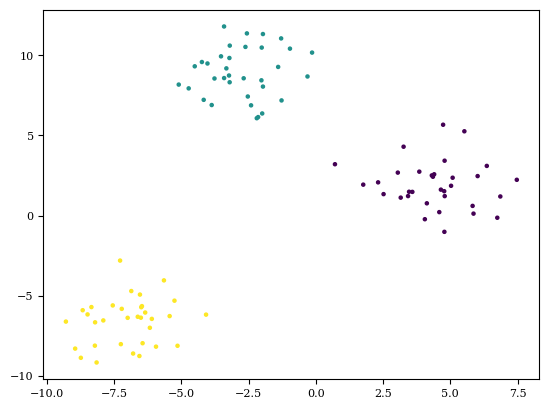

In [ ]:
plt.scatter(x,y,5,c)

here doesn't make much sense, segmentation algorithm will be introduced in one dimension, using the first dimension of freatures and the identified cluster ids

<function matplotlib.pyplot.show(close=None, block=None)>

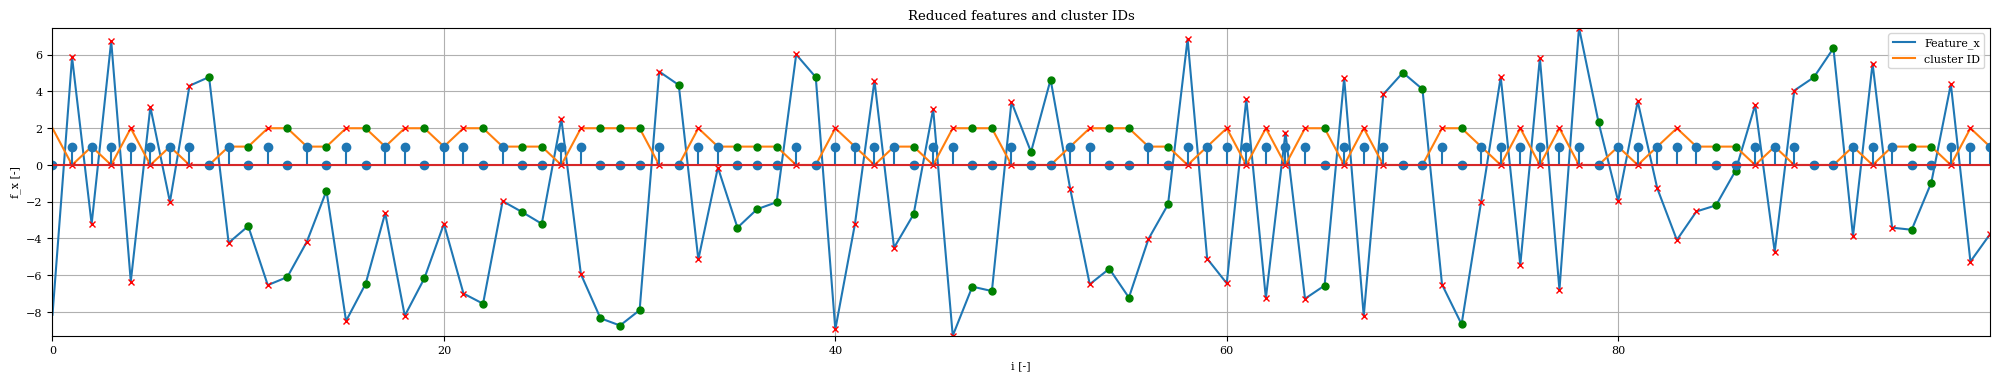

In [ ]:
markersize = 5

fig, ax = plt.subplots(1,1,figsize = [25,4])
ax.plot(x,label='Feature_x')
ax.plot(c,label='cluster ID')

cp = [0]  # let the first feature not to be a changepoint
for k in range(len(c)-1):
    if c[k] == c[k+1]:
        ax.plot(k+1,c[k+1],'go', markersize = markersize)  # , label='same as prev'
        ax.plot(k+1,x[k+1],'go', markersize = markersize)
        cp.append(0)
    else:
        ax.plot(k+1,c[k+1],'rx', markersize = markersize)  # , label='diff from prev'
        ax.plot(k+1,x[k+1],'rx', markersize = markersize)
        cp.append(1)

ax.stem(cp)
plotlabels(ax,'Reduced features and cluster IDs','i [-]','f_x [-]')
plt.legend()
plt.show

* we see, that stems are 0 wherever green dots are
* where green dots are present at $i$, it is in the same cluster as $i-1$
* if stem is one, we found a changepoint

### The elbow method


    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42)

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

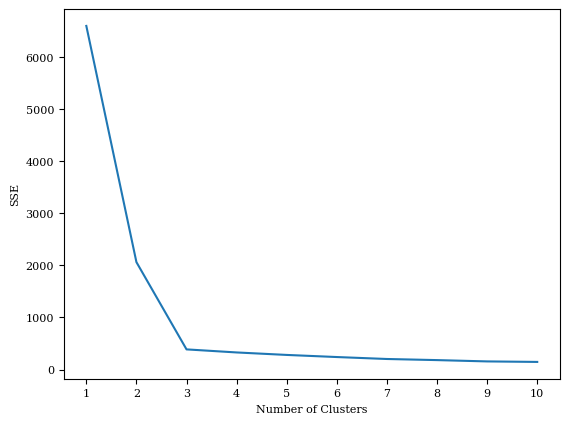

In [ ]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

### The silhouette coefficient


In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)

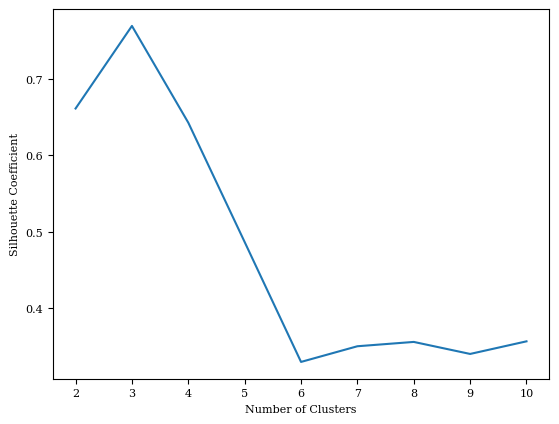

In [ ]:
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Spectrum clustering

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=11,
    max_iter=250,
    random_state=42)

kmeans.fit(np.transpose(P))

"""
from sklearn.metrics import pairwise_distances

kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42,
    metric="cosine"  # <<< no option
)

kmeans.fit(np.transpose(P))
"""

'\nfrom sklearn.metrics import pairwise_distances\n\nkmeans = KMeans(\n    init="random",\n    n_clusters=3,\n    n_init=10,\n    max_iter=300,\n    random_state=42,\n    metric="cosine"  # <<< no option\n)\n\nkmeans.fit(np.transpose(P))\n'

In [ ]:
kmeans.inertia_ # The lowest SSE value

6.87742794980295e-06

In [ ]:
centers = kmeans.cluster_centers_ # Final locations of the centroid
# print(centers)
print(len(centers))

3


In [ ]:
kmeans.n_iter_ # The number of iterations required to converge

13

[1 1 1 ... 1 1 1]
11226


Text(0.5, 1.0, 'Cluster IDs')

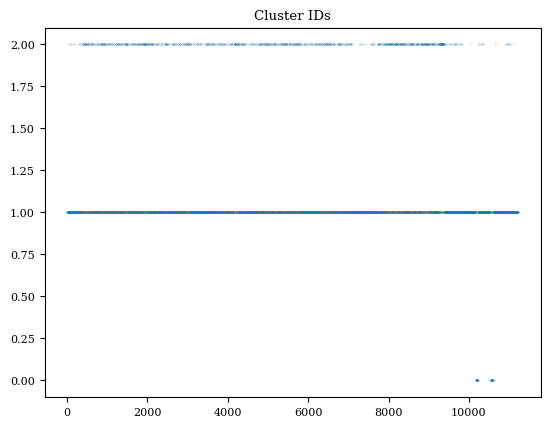

In [ ]:
labels = kmeans.labels_
print(labels)
print(len(labels))

plt.plot(labels, marker = '.', markersize = 0.1, linewidth = 0)
plt.title('Cluster IDs')

Text(0, 0.5, '$X_{wav}$ [-]')

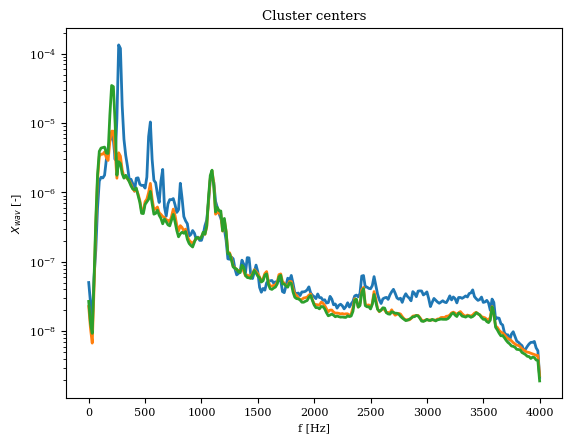

In [ ]:
for k in range(len(centers)):
    plt.plot(F, centers[k], linewidth = 2, scaley  = 'log')

plt.yscale('log')
plt.title('Cluster centers')
plt.xlabel('f [Hz]')
plt.ylabel('$X_{wav}$ [-]')

In [ ]:
"""
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 4])
ax.pcolormesh(T, F, 20*np.log10(P), shading = 'gouraud', cmap='plasma')

# testplot
vector = 4000* np.random.rand(len(T))
ax.plot(T, vector)
"""

"\nfig, ax = plt.subplots(nrows=1, ncols=1, figsize=[10, 4])\nax.pcolormesh(T, F, 20*np.log10(P), shading = 'gouraud', cmap='plasma')\n\n# testplot\nvector = 4000* np.random.rand(len(T))\nax.plot(T, vector)\n"

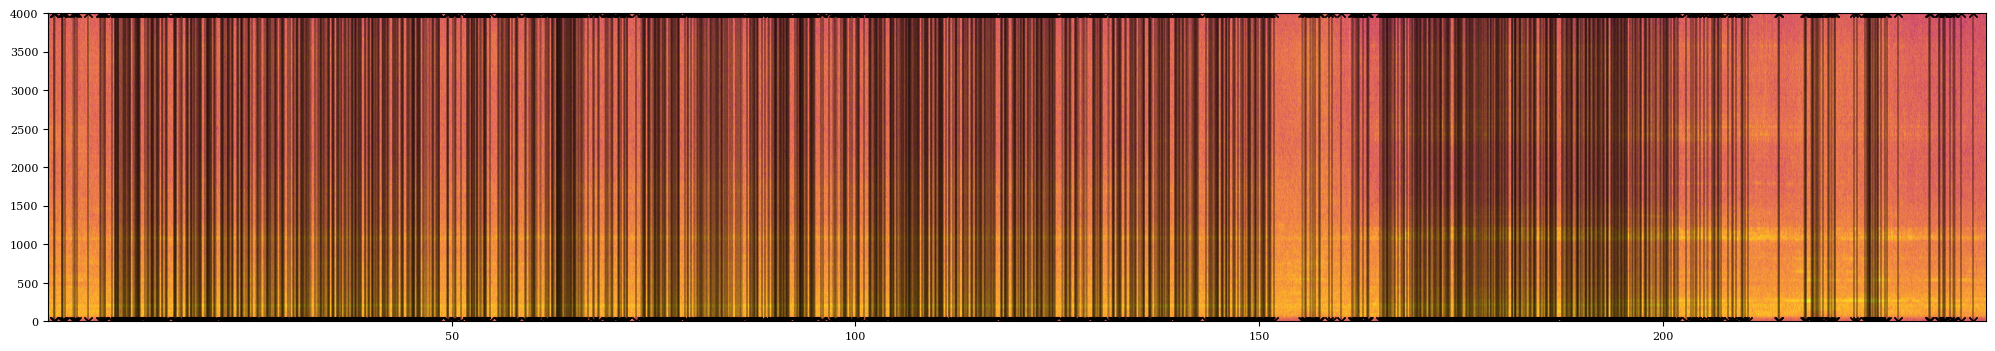

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[25,4])
ax.pcolormesh(T, F, 20*np.log10(P), shading = 'gouraud', cmap='plasma')

cp = [0]  # let the first feature not to be a changepoint
for k in range(len(labels)-1):
    if labels[k] == labels[k+1]:
        # ax.plot( T[k+1], 0,'go', markersize = 5)  # , label='same as prev'
        cp.append(0)
    else:
        # ax.plot( T[k+1], 0,'rx', markersize = 5)  # , label='same as prev'
        cp.append(1)
        ax.plot( [T[k+1],T[k+1]], [0,4000], 'kx-', linewidth = 0.25)

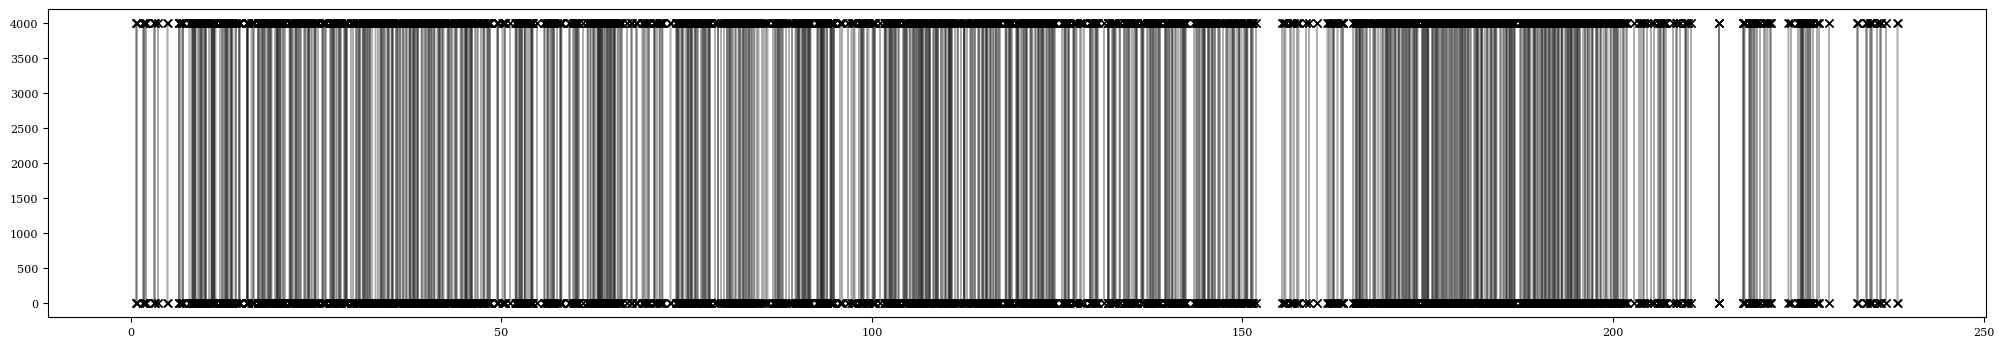

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[25,4])
for k in range(len(labels)-1):
    if labels[k] != labels[k+1]:
        ax.plot( [T[k+1],T[k+1]], [0,4000], 'kx-', linewidth = 0.25)

    kmeans = KMeans(
    init="random",
    n_clusters=10,
    n_init=11,
    max_iter=250,
    random_state=42)

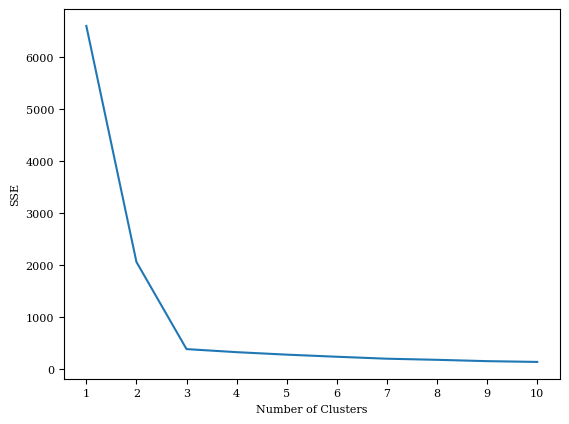

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 11,
    "max_iter": 250,
    "random_state": 42,}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Use different metric

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

class MyKMeans(KMeans):
    def __init__(self, n_clusters=8, init='k-means++', max_iter=300,
                 tol=1e-4, precompute_distances='auto', verbose=0,
                 random_state=None, copy_x=True, n_jobs=None,
                 algorithm='auto'):
        super().__init__(n_clusters=n_clusters, init=init, max_iter=max_iter,
                         tol=tol, precompute_distances=precompute_distances,
                         verbose=verbose, random_state=random_state,
                         copy_x=copy_x, n_jobs=n_jobs,
                         algorithm=algorithm)

    def fit(self, X):
        self.distance_matrix_ = pairwise_distances(X)
        return super().fit(X)

    def _transform(self, X):
        return pairwise_distances(X, self.cluster_centers_, metric=self.distance_matrix_)

egyszerűbben

In [ ]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

user_function = lambda point1, point2: point1[0] + point2[0] + 2
metric = distance_metric(type_metric.USER_DEFINED, func=user_function)

# create K-Means algorithm with specific distance metric
start_centers = [[4.7, 5.9], [5.7, 6.5]];
kmeans_instance = kmeans(sample, start_centers, metric=metric)

# run cluster analysis and obtain results
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()

ModuleNotFoundError: ignored